In [14]:
import torch
import gpytorch
from matplotlib import pyplot as plt
import math
import numpy as np
import pandas as pd
import tqdm.notebook
import time
import DataGrabber
import utils
from sklearn import preprocessing

%matplotlib inline
%load_ext autoreload
%autoreload 2
plt.style.use('classic')

from utils import set_gpytorch_settings

set_gpytorch_settings()

# Command in terminal to help with memory allocation
# set PYTORCH_CUDA_ALLOC_CONF=max_split_size_mb:512

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [15]:
# Kernel Imports
from gpytorch.kernels import PeriodicKernel
from custom_kernel import MinKernel, AR2Kernel, MaternKernel, LinearKernel
from gpytorch.means import ConstantMean
from gpytorch.kernels import ScaleKernel, RBFKernel, InducingPointKernel
from gpytorch.distributions import MultivariateNormal
from gpytorch.constraints import Interval
from custom_kernel import noise_lower, noise_upper, noise_init
import glob
from skimage.measure import block_reduce

174818
[[1.34904934e+09 2.11000004e+01]
 [1.34905114e+09 2.12000008e+01]
 [1.34905293e+09 2.15000000e+01]
 ...
 [1.67713357e+09 1.21999998e+01]
 [1.67713536e+09 1.21000004e+01]
 [1.67713715e+09 1.21000004e+01]]
7285
[[1.34907001e+09 2.04625003e+01]
 [1.34911319e+09 2.08624997e+01]
 [1.34915641e+09 2.03166668e+01]
 ...
 [1.67706426e+09 1.31416666e+01]
 [1.67710836e+09 1.27916665e+01]
 [1.39761355e+08 1.00833337e+00]]


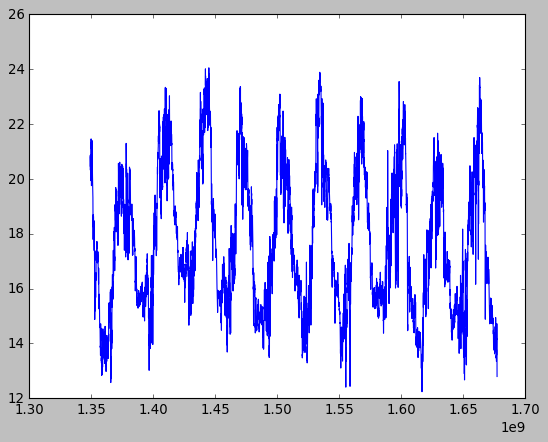

In [16]:

# list_of_file = glob.glob('../data/*.csv')
# out_df = pd.DataFrame()
# for file in list_of_file:
# 	temp_df = pd.read_csv(file, low_memory=False)
# 	out_df = pd.concat([out_df, temp_df])
# out_df.to_csv('../data/combined_data.csv')

def moving_average(data, window_size):
	window = np.ones(int(window_size)) / float(window_size)
	return np.convolve(data, window, 'same')



# pd.read_feather('../data/feather/combined/combined_data.feather')
df = pd.read_feather('../data/feather/46221_9999_wave_height.feather')
df_as_np = df \
    .loc[:, ['time', 'sea_surface_temperature']] \
    .astype(float) \
    .replace(to_replace = [999.0, 99.0, 9999.0], value = np.nan) \
    .to_numpy()
print(len(df_as_np))
print(df_as_np)
# smaller_df = moving_average(df_as_np, window_size=24)
using_sk = block_reduce(df_as_np, block_size=(24,1), func=np.mean).astype(float)
# blk_reduced_smaller = block_reduce(smaller_df, block_size=(24,), func=np.mean).astype(float)
# print(len(smaller_df))
# print(smaller_df)
# using_sk = using_sk.replace(to_replace = 999.0, value = np.nan)
print(len(using_sk))
print(using_sk)
# print(len(blk_reduced_smaller))
# print(blk_reduced_smaller)
# print(using_sk[0:10])
# [(len(using_sk)/2):]
# plt.plot(using_sk[-2000:])
# plt.plot(df_as_np)
# plt.plot(using_sk[:,1])
# plt.plot(using_sk[1,:])
plt.plot(using_sk[:-1,0], using_sk[:-1,1])
# plt.plot(blk_reduced_smaller[-2000:])
# plt.plot(df_as_np)
# plt.plot(df_as_np[len(df_as_np)/2:])
# plt.plot(smaller_df[len(smaller_df)/2:])

In [17]:
# Grab Data and create tensors
# data_grab = DataGrabber.DataGrab(site_number='46221', year='9999', data_type=None) # year=["2020", "2021", "2022"])
# wave_data = data_grab.process_buoy_data()
# print(data_grab.get_vars())
# drop_this_max = wave_data.sea_surface_temperature.max()
# wave_data = wave_data.loc[wave_data.sea_surface_temperature!=drop_this_max]
X = torch.tensor(using_sk[:-1,0]).cuda()
y = torch.tensor(using_sk[:-1,1]).cuda()


# y = torch.tensor(wave_data['sea_surface_temperature'].values.astype(np.float32)).cuda()
# X = torch.tensor(wave_data['time'].values.astype(np.float32)).cuda()

X = X.reshape(-1,1)
# wave_data
X
y
X_old = X
y
print(X)

tensor([[1.3491e+09],
        [1.3491e+09],
        [1.3492e+09],
        ...,
        [1.6770e+09],
        [1.6771e+09],
        [1.6771e+09]], dtype=torch.float64)


In [18]:
# wave_data = wave_data.replace(to_replace = 999.0, value = np.nan)
# wave_data = wave_data.replace(to_replace = 99.0, value = np.nan)
# wave_data = wave_data.replace(to_replace = 9999.0, value = np.nan)
# wave_data['sea_surface_temperature'] = wave_data['sea_surface_temperature']\
#     .replace(to_replace = 999.9, value = np.nan)
#
# # wave_data.to_feather('wave_data.feather')

NameError: name 'wave_data' is not defined

In [20]:
# for name in wave_data.columns:
#     if name != "time":
#         wave_data.plot(x='time', y=name)
y

tensor([20.4625, 20.8625, 20.3167,  ..., 14.1500, 13.1417, 12.7917],
       dtype=torch.float64)

In [ ]:
# print(max(wave_data['sea_surface_temperature']))
# print(min(wave_data['sea_surface_temperature']))
# plt.plot(wave_data['time'], wave_data['sea_surface_temperature'])

In [ ]:
def scaler(a, X_old=X_old, center=True):
    if center is True:
        a = a - X_old.min(0).values
    return a / (X_old.max(0).values - X_old.min(0).values)

# Standardize Data
# print(torch.max(y, 0, keepdim=False))
# torch.dr
# X = (X - X.min(0).values) / (X.max(0).values - X.min(0).values)
X = scaler(X, X_old)
y = y.log()
y = y - torch.min(y)
y = 2 * (y / torch.max(y)) - 1
# Training vs test
from math import floor
#train_n = int(floor(0.9 * len(X)))
# X = preprocessing.normalize(X.cpu())
# y = preprocessing.normalize(y.cpu())
y

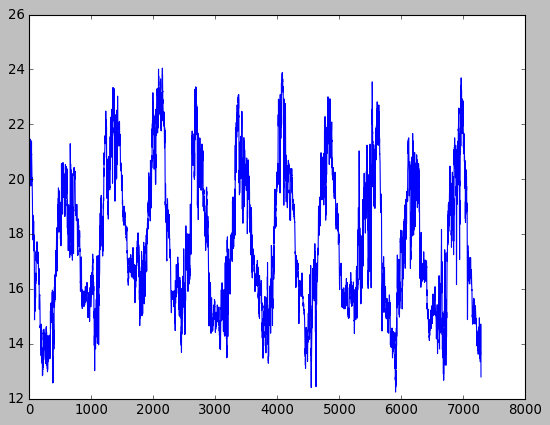

In [21]:
plt.plot(y.cpu())

In [ ]:
series = wave_data['sea_surface_temperature'].diff().diff(48).dropna().iloc[0:100000]
#series = wave_data['sea_surface_temperature']

In [ ]:
plt.plot(series)

In [ ]:
pd.plotting.autocorrelation_plot(series)

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf



plot_acf(series)
plot_pacf(series)

#plot_acf(series, lags=1500)
#plot_pacf(series, lags=1500)

In [ ]:
test_n = 800
train_x = X[test_n:].contiguous().cuda()
train_y = y[test_n:].contiguous().cuda()
test_x = X[-test_n:].contiguous().cuda()
test_y = y[-test_n:].contiguous().cuda()

In [ ]:
print(X.min())
print(X.max())
print(X.mean())

In [ ]:
print(train_x.min())
print(train_x.max())
print(train_x.mean())

print(test_x.min())
print(test_x.max())
print(test_x.mean())

In [ ]:
# Generate the train_loader and train_dataset
train_loader, train_dataset, test_loader, test_dataset = utils.create_train_loader_and_dataset(
    train_x, train_y, test_x, test_y)
data_compact = [train_x, train_y, test_x, test_y, train_loader, train_dataset, test_loader, test_dataset]

In [ ]:
class StandardApproximateGP(gpytorch.models.ApproximateGP):
    def __init__(self, inducing_points, kernel):
        variational_distribution = gpytorch.variational.CholeskyVariationalDistribution(inducing_points.size(-2))
        variational_strategy = gpytorch.variational.VariationalStrategy(
            self, inducing_points, variational_distribution, learn_inducing_locations=True
        )
        super().__init__(variational_strategy)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = kernel

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)


class MeanFieldApproximateGP(gpytorch.models.ApproximateGP):
    def __init__(self, inducing_points, kernel):
        variational_distribution = gpytorch.variational.MeanFieldVariationalDistribution(inducing_points.size(-2))
        variational_strategy = gpytorch.variational.VariationalStrategy(
            self, inducing_points, variational_distribution, learn_inducing_locations=True
        )
        super().__init__(variational_strategy)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = kernel

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)


class MAPApproximateGP(gpytorch.models.ApproximateGP):
    def __init__(self, inducing_points, kernel):
        variational_distribution = gpytorch.variational.DeltaVariationalDistribution(inducing_points.size(-2))
        variational_strategy = gpytorch.variational.VariationalStrategy(
            self, inducing_points, variational_distribution, learn_inducing_locations=True
        )
        super().__init__(variational_strategy)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = kernel

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)


def make_orthogonal_vs(model, train_x):
    mean_inducing_points = torch.randn(1000, train_x.size(-1), dtype=train_x.dtype, device=train_x.device)
    covar_inducing_points = torch.randn(100, train_x.size(-1), dtype=train_x.dtype, device=train_x.device)

    covar_variational_strategy = gpytorch.variational.VariationalStrategy(
        model, covar_inducing_points,
        gpytorch.variational.CholeskyVariationalDistribution(covar_inducing_points.size(-2)),
        learn_inducing_locations=True
    )

    variational_strategy = gpytorch.variational.OrthogonallyDecoupledVariationalStrategy(
        covar_variational_strategy, mean_inducing_points,
        gpytorch.variational.DeltaVariationalDistribution(mean_inducing_points.size(-2)),
    )
    return variational_strategy

class OrthDecoupledApproximateGP(gpytorch.models.ApproximateGP):
    def __init__(self, inducing_points, kernel):
        variational_distribution = gpytorch.variational.DeltaVariationalDistribution(inducing_points.size(-2))
        variational_strategy = make_orthogonal_vs(self, train_x)
        super().__init__(variational_strategy)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = kernel

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

class SpectralDeltaGP(gpytorch.models.ExactGP):
    # def __init__(self, train_x, train_y, kernel, num_deltas, noise_init=None):
    #     likelihood = gpytorch.likelihoods.GaussianLikelihood(noise_constraint=gpytorch.constraints.GreaterThan(1e-11))
    #     likelihood.register_prior("noise_prior", gpytorch.priors.HorseshoePrior(0.1), "noise")
    #     likelihood.noise = 1e-2
    def __init__(self, inducing_points, kernel):
        variational_distribution = gpytorch.variational.DeltaVariationalDistribution(inducing_points)
        #variational_distribution = gpytorch.variational.CholeskyVariationalDistribution(inducing_points.size(-2))
        variational_strategy = gpytorch.variational.VariationalStrategy(
            self, inducing_points, variational_distribution, learn_inducing_locations=True
        )
        #super(SpectralDeltaGP, self).__init__(train_x, train_y, likelihood)
        super().__init__(variational_strategy)
        self.mean_module = gpytorch.means.ConstantMean()
        #base_covar_module = kernel #gpytorch.kernels.SpectralDeltaKernel(num_dims=train_x.size(-1), num_deltas=num_deltas)
        #base_covar_module.initialize_from_data(train_x[0], train_y[0])
        self.covar_module = kernel#gpytorch.kernels.ScaleKernel(base_covar_module)

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)



#likelihood = gpytorch.likelihoods.GaussianLikelihood()
#model = SpectralMixtureGPModel(train_x, train_y, likelihood)

In [ ]:
from gpytorch.kernels import SpectralMixtureKernel

num_deltas = 300
kernel_old = (
        #ScaleKernel(AR2Kernel()) +
        #ScaleKernel(MinKernel()*RBFKernel()) +
        #ScaleKernel(MinKernel())+
        #ScaleKernel(RBFKernel()) +
        #ScaleKernel(RBFKernel()*LinearKernel())+
        ScaleKernel(MaternKernel(nu=0.5)) +
        ScaleKernel(MaternKernel(nu=1.5)*PeriodicKernel(period_length_constraint=Interval(
            lower_bound=1e-4,
            upper_bound=0.1,
            initial_value=0.01
        ))) +
        ScaleKernel(MaternKernel(nu=1.5)*PeriodicKernel(period_length_constraint=Interval(
            lower_bound=0.05,
            upper_bound=0.3,
            initial_value=0.15
        ))) +
        ScaleKernel(MaternKernel(nu=1.5)*PeriodicKernel(period_length_constraint=Interval(
            lower_bound=0.25,
            upper_bound=1,
            initial_value=0.5
        ))) +
        ScaleKernel(gpytorch.kernels.SpectralDeltaKernel(
            num_dims=train_x.size(-1),
            num_deltas=num_deltas,
        )) +
        ScaleKernel(gpytorch.kernels.SpectralMixtureKernel(num_mixtures=4))
        #ScaleKernel(RBFKernel()*PeriodicKernel())
        )

In [ ]:
k4_spectral_base = SpectralMixtureKernel(num_mixtures=4)
k4_spectral_base.initialize_from_data_empspect(train_x, train_y)

In [ ]:
import copy

k1 = copy.deepcopy(k4_spectral_base)

k2 = copy.deepcopy(k4_spectral_base) *PeriodicKernel(
    period_length_constraint=Interval(
    lower_bound=1/4000,
    upper_bound=5/(2*365),
    initial_value=1/(365*2))
)

k3 = ScaleKernel(MaternKernel(nu=1.5)*PeriodicKernel(
    period_length_constraint=Interval(
    lower_bound=1/4000,
    upper_bound=10/(2*365),
    initial_value=1/(2*365))
))

k4 = ScaleKernel(MaternKernel(nu=0.5))

In [ ]:
scaler(60*24, center=False)  # minutes

In [ ]:
scaler(60*24*30, center=False)  # minutes

In [ ]:
Mat32 = MaternKernel(nu=1.5)

# Per_Day = PeriodicKernel(
#     period_length_constraint=Interval(
#     lower_bound=scaler(60*24, center=False) / 100,
#     upper_bound=scaler(60*24, center=False) * 100,
#     initial_value=scaler(60*24, center=False))
# )

Per_Month = PeriodicKernel(
    period_length_constraint=Interval(
    lower_bound=scaler(60*24*30, center=False) / 100,
    upper_bound=scaler(60*24*30, center=False) * 100,
    initial_value=scaler(60*24*30, center=False))
)

# kernel = (
# 	k1 + k3 + k4
#     # not: ScaleKernel(k1+k2) since they all have spectral component
# )

kernel = (
	ScaleKernel(Mat32) +
    # ScaleKernel(Per_Day) +
    ScaleKernel(Per_Month)
    # not: ScaleKernel(k1+k2) since they all have spectral component
)


likelihood = gpytorch.likelihoods.GaussianLikelihood(noise_constraint = Interval(noise_lower, noise_upper,initial_value=noise_init))



In [ ]:
# gpytorch.settings.cholesky_max_tries._set_value(100)
# gpytorch.settings.max_cholesky_size._set_value(1000)
gpytorch.settings.cholesky_jitter._set_value(double_value=1e8, float_value=1e-4, half_value=1e-3)
num_ind_pts = 128 # Number of inducing points (128 is default for train_and_test_approximate_gp function)
num_epochs = 15

#m1, l1 = utils.train_and_test_approximate_gp(
#    StandardApproximateGP, kernel, *data_compact, num_epochs=100, num_ind_pts=num_ind_pts)
# m2, l2 = utils.train_and_test_approximate_gp(
#     MeanFieldApproximateGP, kernel, *data_compact, num_epochs=100, num_ind_pts=num_ind_pts)
# m3, l3 = utils.train_and_test_approximate_gp(
#     MAPApproximateGP, kernel, *data_compact, num_epochs=100, num_ind_pts=num_ind_pts)
# m4, l4 = utils.train_and_test_approximate_gp(
#     OrthDecoupledApproximateGP, kernel, *data_compact, num_epochs=100, num_ind_pts=num_ind_pts)
# m5, l5 = utils.train_and_test_approximate_gp(
#     SpectralDeltaGP, kernel, *data_compact, num_epochs=100, num_ind_pts=num_deltas)
# m6, l6 = utils.train_and_test_approximate_gp(
#     SpectralMixtureGPModel, kernel, *data_compact, num_epochs=100, num_ind_pts=num_deltas)
#l1 = gpytorch.likelihoods.GaussianLikelihood()
#m1 = SpectralMixtureGPModel(train_x, train_y, likelihood)
m1, l1 = utils.train_and_test_approximate_gp(
    StandardApproximateGP, kernel, *data_compact, num_epochs=num_epochs, num_ind_pts=num_ind_pts)
#print(kernel.kernels[2].base_kernel.lengthscale)
m2, l2 = utils.train_and_test_approximate_gp(
    OrthDecoupledApproximateGP, kernel, *data_compact, num_epochs=num_epochs, num_ind_pts=num_ind_pts)
#print(kernel.kernels[2].base_kernel.lengthscale)


In [ ]:
print(m1.covar_module.kernels[0].outputscale)
print(m1.covar_module.kernels[1].outputscale)
# print(m1.covar_module.kernels[2].outputscale)


print(m2.covar_module.kernels[0].outputscale)
print(m2.covar_module.kernels[1].outputscale)
# print(m2.covar_module.kernels[2].outputscale)



In [ ]:
pairs = [[m1, l1],
        [m2, l2],]# [m3, l3],
#         [m4, l4], [m5, l5],
        #[m1, l1]]

for pair in pairs:
    model = pair[0]
    likelihood = pair[1]
    model.eval()
    # Make predictions by feeding model through likelihood
    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        observed_pred = likelihood(model(test_x))
    # Initialize plot
    f, ax = plt.subplots(1, 1, figsize=(10, 7))
    # Get upper and lower confidence bounds
    lower, upper = observed_pred.confidence_region()
    # Shade between the lower and upper confidence bounds
    ax.fill_between(test_x[:,0].detach().cpu().numpy(),
                    lower.detach().cpu().numpy(),
                    upper.detach().cpu().numpy(), alpha=0.3)
    # Plot training data as black stars
    ax.scatter(train_x[:,0].detach().cpu().numpy(), train_y.detach().cpu().numpy(), s=0.5)
    #ax.scatter(model.variational_strategy.inducing_points[:,0].detach().cpu().numpy(),
    #           np.zeros(500)+1, s=0.5)
    # Plot predictive means as blue line
    ax.plot(test_x[:,0].detach().cpu().numpy(), observed_pred.mean.detach().cpu().numpy(), 'blue')
    ax.scatter(
        test_x[:,0].detach().cpu().numpy(),
        test_y.detach().cpu().numpy(),
        s=1, color="red")
    # ax.set_xlim(.999,1)
    ax.set_xlim(0,1)
    #ax.set_xlim(0.65,0.75)
    ax.vlines(m1.variational_strategy.inducing_points.detach().cpu().numpy(), ymin = -1.6, ymax = -1.5)

    #ax.set_ylim([0, 1.5])
    #ax.patch.set_facecolor('green')
    #ax.patch.set_alpha(.1)
    ax.legend(["95% Credible Intervals", "Observed Data", "Posterior Mean"])

In [ ]:
test_x.shape

In [ ]:
train_x


In [ ]:
with torch.no_grad():
    m1(test_x)

In [ ]:
# for i in range(len(m1.covar_module.kernels)):
#     print(m1.covar_module.kernels[i].outputscale)
torch.cuda.memory_summary()

In [ ]:
from utils import get_BIC

print(get_BIC(m1, likelihood, train_y, train_x))

In [ ]:
m1.eval()
likelihood.eval()

with torch.no_grad(), gpytorch.settings.fast_pred_var():
    observed_pred = likelihood(m1(test_x))


In [ ]:
# Initialize plot
f, ax = plt.subplots(1, 1, figsize=(10, 7))

# Get upper and lower confidence bounds
lower, upper = observed_pred.confidence_region()
# Shade between the lower and upper confidence bounds
ax.fill_between(test_x.detach().cpu().numpy(),
                lower.detach().cpu().numpy(),
                upper.detach().cpu().numpy(), alpha=0.3)
# Plot training data as black stars
ax.scatter(train_x.detach().cpu().numpy(), train_y.detach().cpu().numpy(), s=0.5)
# Plot predictive means as blue line
ax.plot(test_x.detach().cpu().numpy(), observed_pred.mean.detach().cpu().numpy(), 'blue')

ax.set_ylim([0, 1.5])
#ax.patch.set_facecolor('green')
#ax.patch.set_alpha(.1)
ax.legend(["95% Credible Intervals", "Observed Data", "Posterior Mean"])